# Airbnb - Rio de Janeiro
* Download [data](http://insideairbnb.com/get-the-data.html)
* We downloaded `listings.csv` from all monthly dates available

## Questions
1. What was the price and supply behavior before and during the pandemic?
2. Does a title in English or Portuguese impact the price?
3. What features correlate with the price? Can we predict a price? Which features matters?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_pickle("treated_data.pkl")
df.head()

,id,date,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,language,appearances
0,17878,2018-04-14,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,5.598422,1.386294,5.327876,last_week,1.153732,0.000000,5.659482,en,0.0
1,24480,2018-04-14,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,5.402677,1.098612,4.454347,last_half_year,0.652325,0.000000,0.000000,en,0.0
2,25026,2018-04-14,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,5.081404,1.386294,5.342334,last_month,1.153732,1.098612,5.897154,en,0.0
3,31560,2018-04-14,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,5.402677,0.693147,5.303305,last_month,1.137833,0.000000,5.846439,en,0.0
4,35636,2018-04-14,153232,Ipanema,-22.988165,-43.193588,Entire home/apt,5.730100,0.693147,4.762174,last_month,1.141033,0.000000,4.867534,en,0.0


In [3]:
df.columns = ["Id", "Scraping Date", "Host Id", 
              "Neighbourhood", "Latitude", "Longitude", "Room Type", "Price", "Minimum Nights",
              "Number of Reviews", "Last Review", "Reviews per Month", "Calc. Host List. Count",
              "Availability 365", "Title Language", "Appearances"
             ]

## Correlation Analysis

### Geographic Analysis
* Price is negatively correlated with Latitude (more strongly) and Longitude. 
* Southern part of the city is where beaches are located, and it is the most expensive. Specially Zona Sul and Barra da Tijuca regions.
* Western parts being more valuable might indicate that Barra da Tijuca region are higher priced than Zona Sul, which is a bit unexpected, because most turistic part of Rio is in Zona Sul and nearear regions (which are more eastern).

### Review Analysis
* This is an interesting one. The listings with more reviews tend to be lower priced.
* Probably people reviews more when they have a complaint than when they are satisfied.
* Good indication to do a sentiment analysis of the reviews to confirm this hypothesis.

### Host Analysis
* Listings with higher minimum nights tend to higher priced.
* The quantity of listings per host and the number of appearances of a listing does not seem to impact price much.
* Highly available listings tend to have a slighly lower price.

<AxesSubplot:>

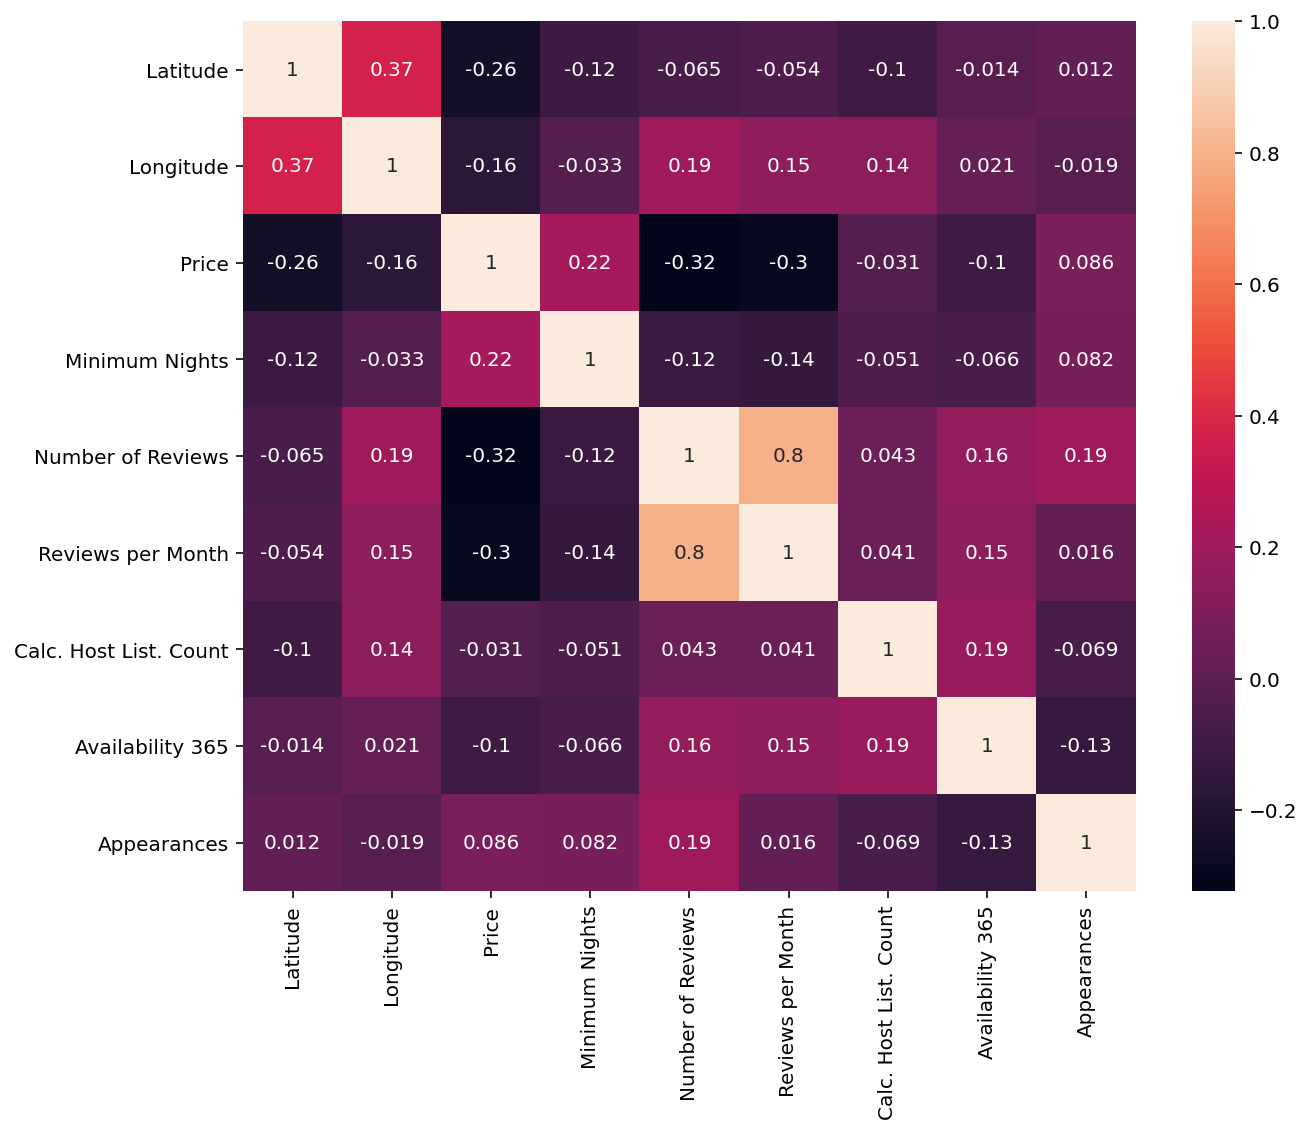

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.loc[:, "Latitude":].corr(), annot=True)

### Geographic Analysis
* The Spatial distribution of prices shows that Barra da Tijuca and Zona Sul regions really have higher prices
* Barra da Tijuca have a median price greater than and Copabana, Ipanema (Zona Sul neighbourhoods)

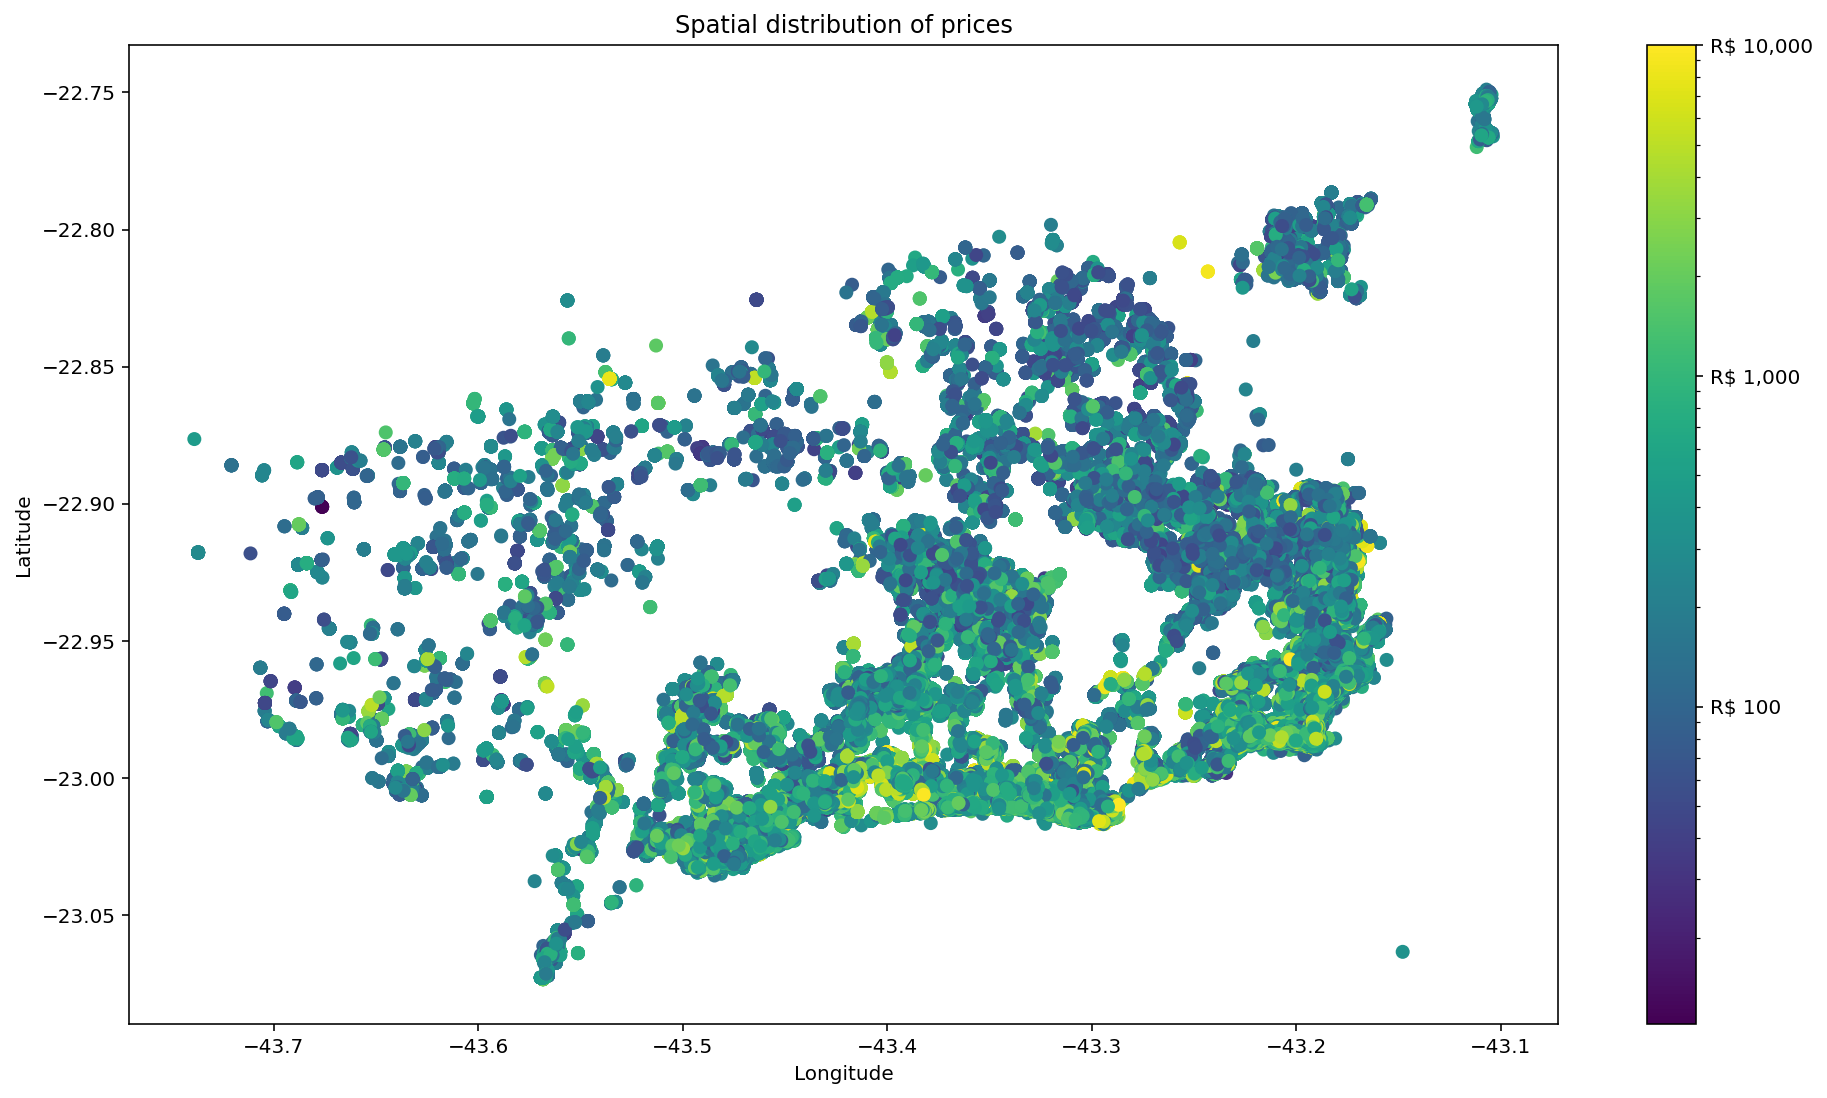

In [5]:
plt.figure(figsize=(16,9))
plt.scatter(df["Longitude"], df["Latitude"], c=np.exp(df["Price"]), cmap="viridis", norm=matplotlib.colors.LogNorm())
plt.colorbar(format=matplotlib.ticker.StrMethodFormatter('R$ {x:,.0f}'))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial distribution of prices")
plt.show()

In [6]:
# Neighborhoods with more than 30 rooms per month
filt = (df.groupby(["Neighbourhood", "Scraping Date"])["Id"].count() >= 30).unstack().all(axis=1)

# Median Price by Neighborhood for Last year only, considering only neighbourhoods with more than 30 rooms per month
np.exp(df[df["Scraping Date"] >= "2020-01-01"].groupby(["Neighbourhood"])["Price"].median()).sort_values(ascending=False)[filt]

Neighbourhood
Joá                         1481.999663
Lagoa                        498.000000
São Conrado                  482.000000
Leblon                       450.000000
Barra da Tijuca              443.000000
Maracanã                     400.000000
Jacarepaguá                  400.000000
Ipanema                      399.000000
Engenho de Dentro            398.000000
Recreio dos Bandeirantes     395.000000
Gávea                        353.000000
Jardim Botânico              351.000000
Freguesia (Jacarepaguá)      300.000000
Vargem Grande                300.000000
Guaratiba                    300.000000
Itanhangá                    298.000000
Humaitá                      298.000000
Leme                         298.000000
Vargem Pequena               298.000000
Camorim                      298.000000
Pechincha                    286.000000
Urca                         278.000000
Anil                         278.000000
Barra de Guaratiba           262.000000
Cosme Velho               

# Time Series Analysis

## Observations
* We have data from 30 months, starting Apr-2018, skipping some months.
* High season is during summer time and end of year, e.g. December, January
* Low season is around July, August
* During the pandemic we have several changes mostly prices and listings supply
* Hosts tend to put higher prices in English listings than in Portuguese
* We have more listings in Portuguese than in English

## Pandemic Mar-2020 to date
* Unfortunately, we do not have data for Aug-2020 and Sept-2020 when a we had a great change
* However, we can split the behavior into two periods: Mar-2020 to July-2020 and Sept-2020 to Dec-2020

### First period (Mar-2020 to July-2020)
* During the first period, we do not have a shock in supply, which is unexpected, specially in March and April, when we had several lockdowns.
* The other unexpected behavior was that prices were kept the same. We expected that both the pandemic (due to probable decrease in demand) or seasonal effect to decrease price, but that did not happen.
* There was a price hike for listings in English
* There was a increase of listing supply in Portuguese in detriment of those in English
* There is a long term decrease in English listings (not only due to pandemic)
* There wasn't much change of counts for Room Types

* We can work with several hypothesis:
1. Hosts kept or increased price due to the devaluation of BRL (although not enough to compensate)
2. Hosts increased listings in Portuguese to cater to local tourists (due to flight restrictions...)
3. Hosts were afraid of losing income and tried to keep going and try their chances
4. Hosts with listings in English reacts more actively to devaluations

### Second Period (Sept-2020 to Dec-2020)
* We can see in this period a stark change in behavior
* The market has bottomed and rebounced quickly (in terms of price)
* The supply was sharpely reduced from around 35000 to 20000, almost 50% decrease!
* The price initially also decreased from around 300 BRL to 260 BRL (13% decrease), but in December jumped to 350 BRL (a 34% increase from bottom and 16% increase from July)

* Hypothesis:
1. Price was pressed due to low demand, despite a big decrease in supply
2. The relaxation of restrictions played a role in increasing demand amid a short supply, the prices have gone up
3. Hosts tried to keep supply and prices (first period), however the lack of demand took its toll and the expected shock in supply and prices happened after a delay (second period)

In [7]:
# Exchange rate
usd = pd.read_csv("data/usd-brl-exchange-rate.csv")
usd["DATE"] = pd.to_datetime(usd["DATE"], yearfirst=True, infer_datetime_format=True)
usd["USD-BRL"] = usd["USD-BRL"].str.replace(",", ".").astype(float)
usd = usd.set_index("DATE")
usd = usd["USD-BRL"]
usd = usd.resample("M").mean()
usd.head()

DATE
2018-04-30    3.41
2018-05-31    3.64
2018-06-30    3.77
2018-07-31    3.83
2018-08-31    3.93
Freq: M, Name: USD-BRL, dtype: float64

In [8]:
# Overall
overall_median_price = np.exp(df.groupby(["Scraping Date"])["Price"].median()).resample("M").mean()
overall_median_price_usd = overall_median_price.divide(usd, axis=0)
overall_listing_count = df.groupby(["Scraping Date"])["Price"].count().resample("M").mean()

# By Room Type
room_type_median_price = np.exp(df.groupby(["Scraping Date", "Room Type"])["Price"].median().unstack().resample("M").mean())
room_type_median_price_usd = room_type_median_price.divide(usd, axis=0)
room_type_listing_count = df.groupby(["Scraping Date", "Room Type"])["Price"].count().unstack().resample("M").mean()

# By Title Language
lang_median_price = np.exp(df.groupby(["Scraping Date", "Title Language"])["Price"].median().unstack().resample("M").mean())
lang_median_price_usd = lang_median_price.divide(usd, axis=0)
lang_listing_count = df.groupby(["Scraping Date", "Title Language"])["Price"].count().unstack().resample("M").mean()

<AxesSubplot:xlabel='Scraping Date', ylabel='Count'>

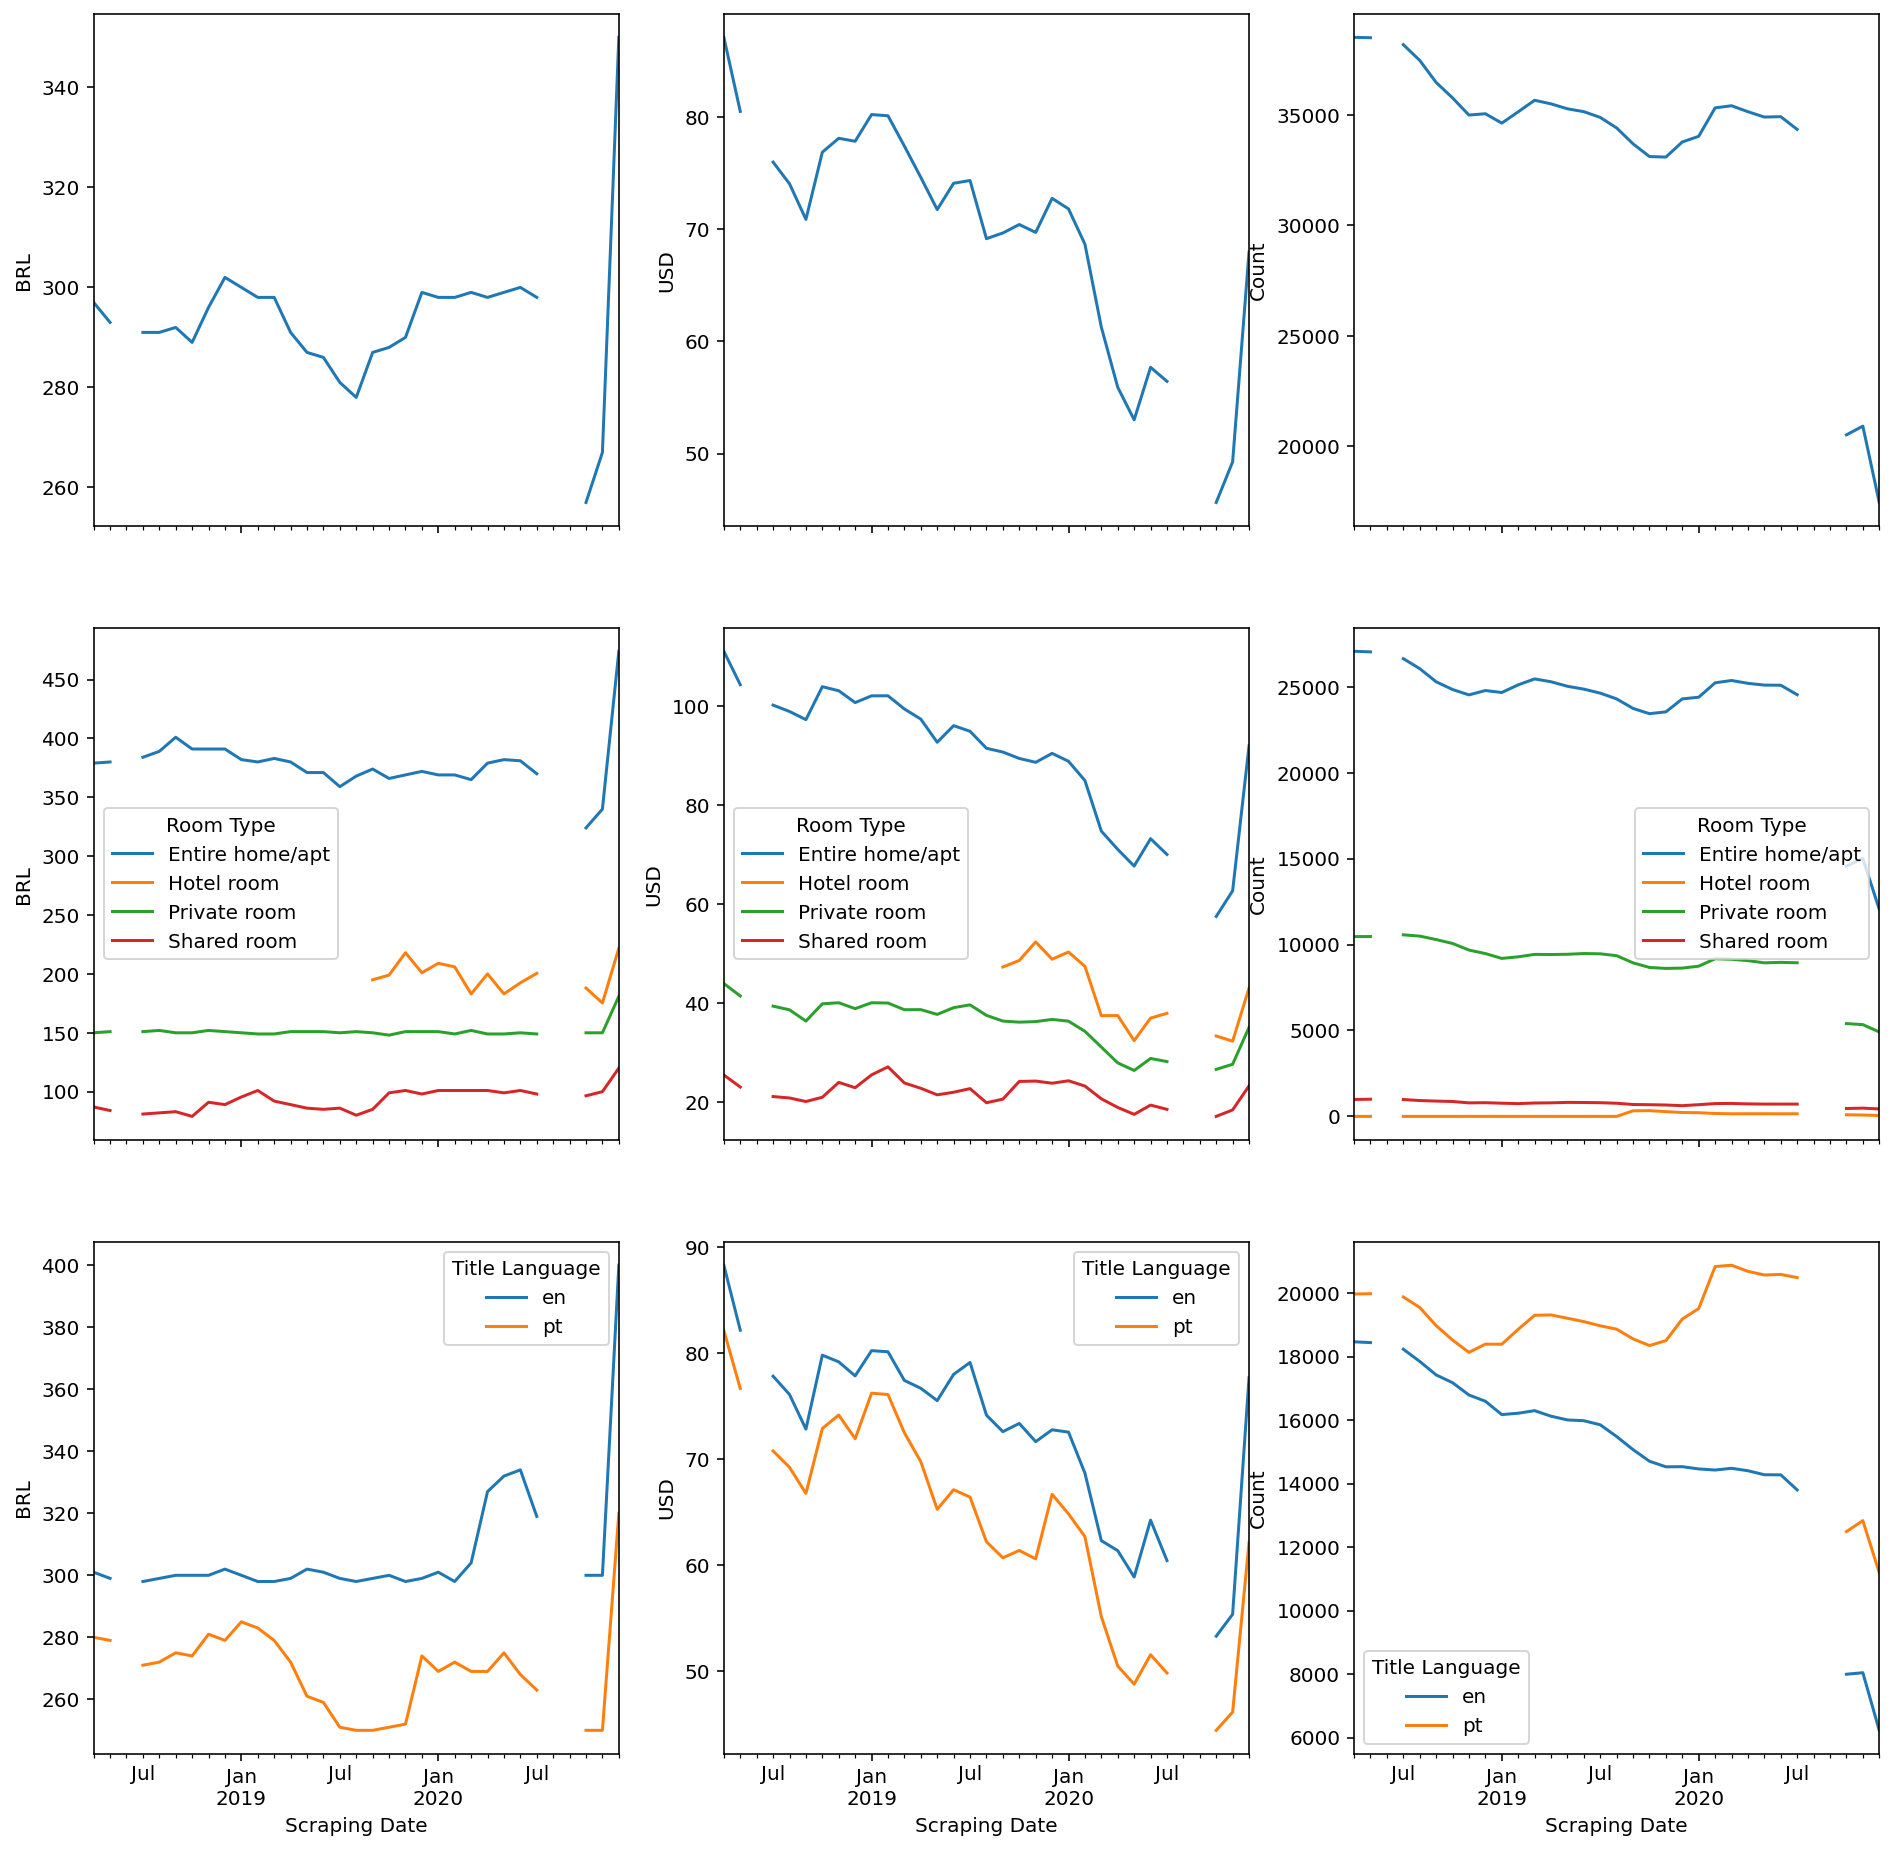

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(16,16))

overall_median_price.plot(ax=axes[0,0], ylabel="BRL")
overall_median_price_usd.plot(ax=axes[0,1], ylabel="USD")
overall_listing_count.plot(ax=axes[0,2], ylabel="Count")

room_type_median_price.plot(ax=axes[1,0], ylabel="BRL")
room_type_median_price_usd.plot(ax=axes[1,1], ylabel="USD")
room_type_listing_count.plot(ax=axes[1,2], ylabel="Count")

lang_median_price.plot(ax=axes[2,0], ylabel="BRL")
lang_median_price_usd.plot(ax=axes[2,1], ylabel="USD")
lang_listing_count.plot(ax=axes[2,2], ylabel="Count")

<AxesSubplot:xlabel='Scraping Date'>

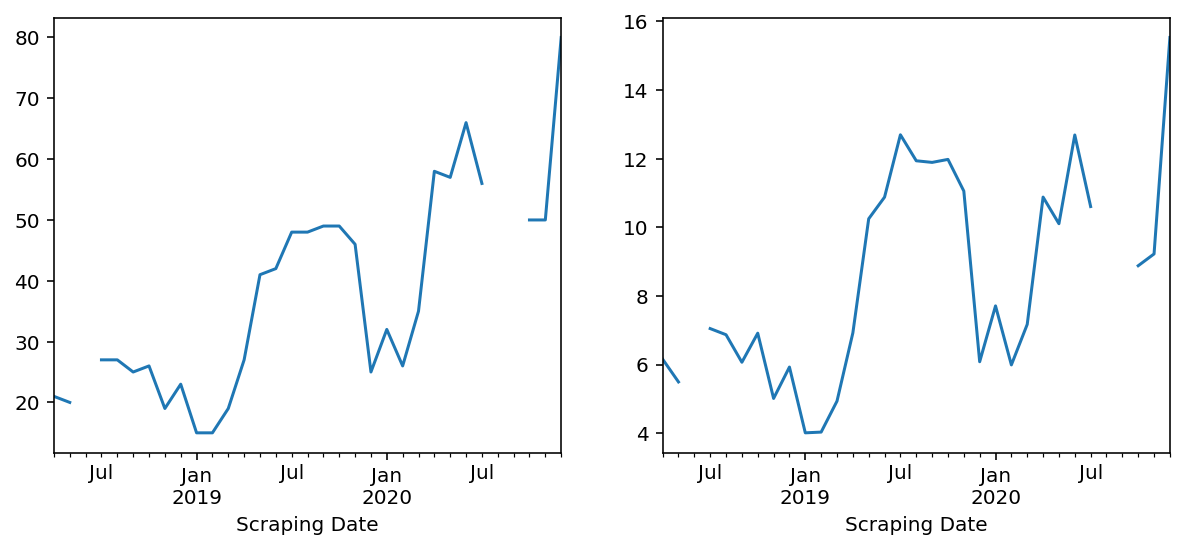

In [10]:
# Difference between English and Portuguese median price
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,4))

premium = df.groupby("Scraping Date").apply(
    lambda group: np.exp(group[group["Title Language"]=="en"]["Price"].median()) -
        np.exp(group[group["Title Language"]=="pt"]["Price"].median()))

premium.resample("M").mean().plot(ax=axes[0])
premium.resample("M").mean().divide(usd, axis=0).plot(ax=axes[1])

### Test Statistics
* Check significancy of different means between price in Portuguese and English
* Checked normality using Anderson–Darling because of large samples
* Checked homoscedasticity using Levene
* Failed Levene, using Welch's test

* P-Value < 0.05 for all scraping dates, we reject that the mean of prices in Portuguese are equal from those in English

In [11]:
# Normality 5% sign. level
# All must be true to not reject normality
df.groupby(["Scraping Date", "Title Language"]).apply(
    lambda group: stats.anderson(group["Price"])[1][2]) > 0.05

Scraping Date  Title Language
2018-04-14     en                True
               pt                True
2018-05-17     en                True
               pt                True
2018-07-13     en                True
               pt                True
2018-08-16     en                True
               pt                True
2018-09-14     en                True
               pt                True
2018-10-12     en                True
               pt                True
2018-11-15     en                True
               pt                True
2018-12-14     en                True
               pt                True
2019-01-18     en                True
               pt                True
2019-02-11     en                True
               pt                True
2019-03-13     en                True
               pt                True
2019-04-16     en                True
               pt                True
2019-05-21     en                True
               pt   

In [12]:
# Check homoscedasticity
# All must be true to not reject equality of variance
df.groupby("Scraping Date").apply(
    lambda group: stats.levene(group[group["Title Language"]=="pt"]["Price"], 
                                 group[group["Title Language"]=="en"]["Price"])[1]) > 0.05

Scraping Date
2018-04-14     True
2018-05-17     True
2018-07-13     True
2018-08-16     True
2018-09-14     True
2018-10-12     True
2018-11-15     True
2018-12-14     True
2019-01-18     True
2019-02-11     True
2019-03-13     True
2019-04-16    False
2019-05-21    False
2019-06-19    False
2019-07-15    False
2019-08-15    False
2019-09-23    False
2019-10-19    False
2019-11-22    False
2019-12-23    False
2020-01-21    False
2020-02-25    False
2020-03-18    False
2020-04-20    False
2020-05-24    False
2020-06-19    False
2020-07-22    False
2020-10-25    False
2020-11-27    False
2020-12-23    False
dtype: bool

In [13]:
# Welch's t-Test
# All must be true to reject same mean
df.groupby("Scraping Date").apply(
    lambda group: stats.ttest_ind(group[group["Title Language"]=="pt"]["Price"], 
                                 group[group["Title Language"]=="en"]["Price"], equal_var=False)[1]) < 0.05

Scraping Date
2018-04-14    True
2018-05-17    True
2018-07-13    True
2018-08-16    True
2018-09-14    True
2018-10-12    True
2018-11-15    True
2018-12-14    True
2019-01-18    True
2019-02-11    True
2019-03-13    True
2019-04-16    True
2019-05-21    True
2019-06-19    True
2019-07-15    True
2019-08-15    True
2019-09-23    True
2019-10-19    True
2019-11-22    True
2019-12-23    True
2020-01-21    True
2020-02-25    True
2020-03-18    True
2020-04-20    True
2020-05-24    True
2020-06-19    True
2020-07-22    True
2020-10-25    True
2020-11-27    True
2020-12-23    True
dtype: bool